用到的库

In [151]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib
tfd = tfp.distributions
tfb = tfp.bijectors

这是一个裂纹size关于circle次数N的预测。
裂纹size a 服从此关系：
\begin{align}
a(N)=\left[N C\left(1-\frac{m}{2}\right)(\Delta \sigma \sqrt{\pi})^{m}+a_{o}^{1-\frac{m}{2}}\right]^{\frac{2}{2-m}}
\end{align}
其中$(C,m)$是材料性质，$a_0$是初始裂纹，$\sigma$为应力。
裂痕size和N的关系为

![裂痕size和N的关系](./fig/f1.png)

假设$(C,m)$的先验分布服从高斯分布：
$$
\begin{gathered}
\log C^{\text {prior }} \sim N\left(\mu=-23, \sigma^{2}=1.1\right) \\
m^{\text {prior }} \sim N\left(\mu=4, \sigma^{2}=0.2\right)
\end{gathered}
$$
在TensorFlow Probability (TFP) 中可以用以下代码表示这个先验：

In [152]:
tfd = tfp.distributions
prio_par_logC = [-23., 1.1] # [location, scale] for Normal Prior
prio_par_m = [4., 0.2] # [location, scale] for Normal Prior
rv_logC = tfd.Normal(loc=0., scale=1., name='logC_norm')# Normal, mean=0,std=1
rv_m = tfd.Normal(loc=0., scale=1., name='m_norm')

In [153]:
rv_logC.log_prob(prio_par_logC) 

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-265.41895  ,   -1.5239385], dtype=float32)>

定义联合概率分布的$log$

In [154]:
def joint_log_prob(cycles, observations, y0, logC_norm, m_norm):
    # Joint logProbability function for both random variables and observations.
    # Some constants
    dsig = 75.
    B = tf.constant(dsig * np.pi**0.5, tf.float32)
    # Computing m and logC on original space
    logC = logC_norm * prio_par_logC[1]**0.5+ prio_par_logC[0] # 
    m = m_norm * prio_par_m[1]**0.5 + prio_par_m[0]
    # Crack Propagation model 建模观测值和crack模型(式1)之间的差值，y0即为crack模型的a0
    crack_model =(cycles * tf.exp(logC) * (1 - m / 2.) * B**m + y0**(1-m / 2.))**(2. / (2. - m))
    y_model = observations - crack_model
    # Defining child model random variable #似然函数
    rv_model = tfd.Independent(
        tfd.Normal(loc=tf.zeros(observations.shape), scale=0.001),
       reinterpreted_batch_ndims=1, name = 'model')
    # Sum of logProbabilities 先验概率*似然函数 = 后验概率 -- 贝叶斯公式
    return rv_logC.log_prob(logC_norm) + rv_m.log_prob(m_norm) + rv_model.log_prob(y_model)

下面为真实测量的数据，
t为 cycles数，
y为 crack size，
共16个点。

In [155]:
# true values of the parameters
t = tf.range(0.,1600., 100) #cycles
y = tf.constant([0.0100,0.0109,0.0101,0.0107,0.0110,0.0123,0.0099,0.0113, 
   0.0132,0.0138,0.0148,0.0156,0.0155,0.0141,0.0169,0.0168]) # measured crack size data

使用 MCMC 作为 sampler，实际在求在知道一些真实测量数据后 $(C,m)$的后验分布，使用马尔可夫过程是因为cycle是个时序过程，与前一刻历史相关，并从 $a_0$ or $y_0$ 开始。

In [156]:
# This cell can take ～10 minutes to run in Graph mode
# Number of samples and burnin for the MCMC sampler
samples = 3000
burnin = 3000

# Initial state for the HMC
initial_state = [0., 0.]
# Converting the data into tensors 把测量数据变成张量形式
cycles = tf.convert_to_tensor(t,tf.float32)
observations = tf.convert_to_tensor(y,tf.float32) # measured crack siz
y0 = tf.convert_to_tensor(y[0], tf.float32) #第0个观测数据，变成张量形式

# Setting up a target posterior for our joint logprobability
unormalized_target_posterior= lambda *args: joint_log_prob(cycles, observations, y0, *args)
# And finally setting up the mcmc sampler 使用 MCMC 采集数据
[logC_samples, m_samples], kernel_results = tfp.mcmc.sample_chain( # 采用结果和接受率
    num_results= samples, 
    num_burnin_steps= burnin,
    current_state=initial_state,
    kernel= tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unormalized_target_posterior,
        step_size = 0.045, 
        num_leapfrog_steps=6))

# Tracking the acceptance rate for the sampled chain
acceptance_rate = tf.reduce_mean(tf.cast(kernel_results.is_accepted,tf.float32)) #将bool张量转成float并求平均值
print('acceptance_rate:', acceptance_rate)

acceptance_rate: tf.Tensor(0.55366665, shape=(), dtype=float32)


输出MCMC采样后的结果，显然两个随机变量负相关

Text(0.5, 1.0, 'm samples')

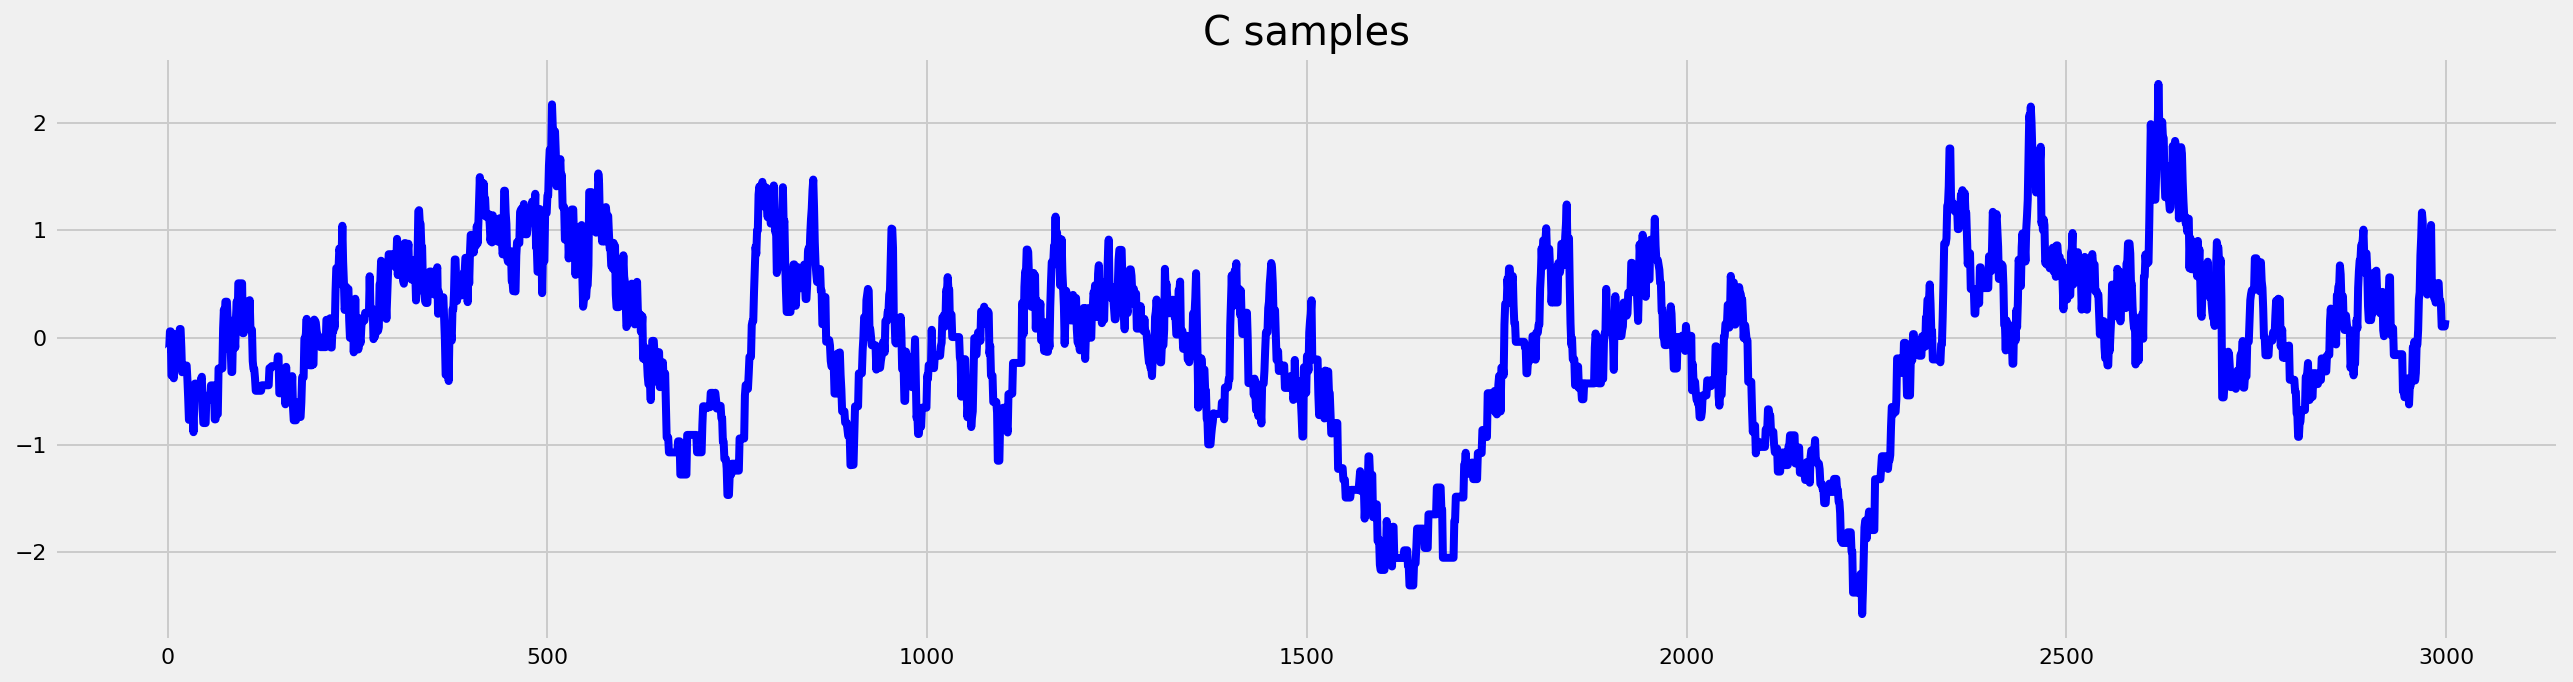

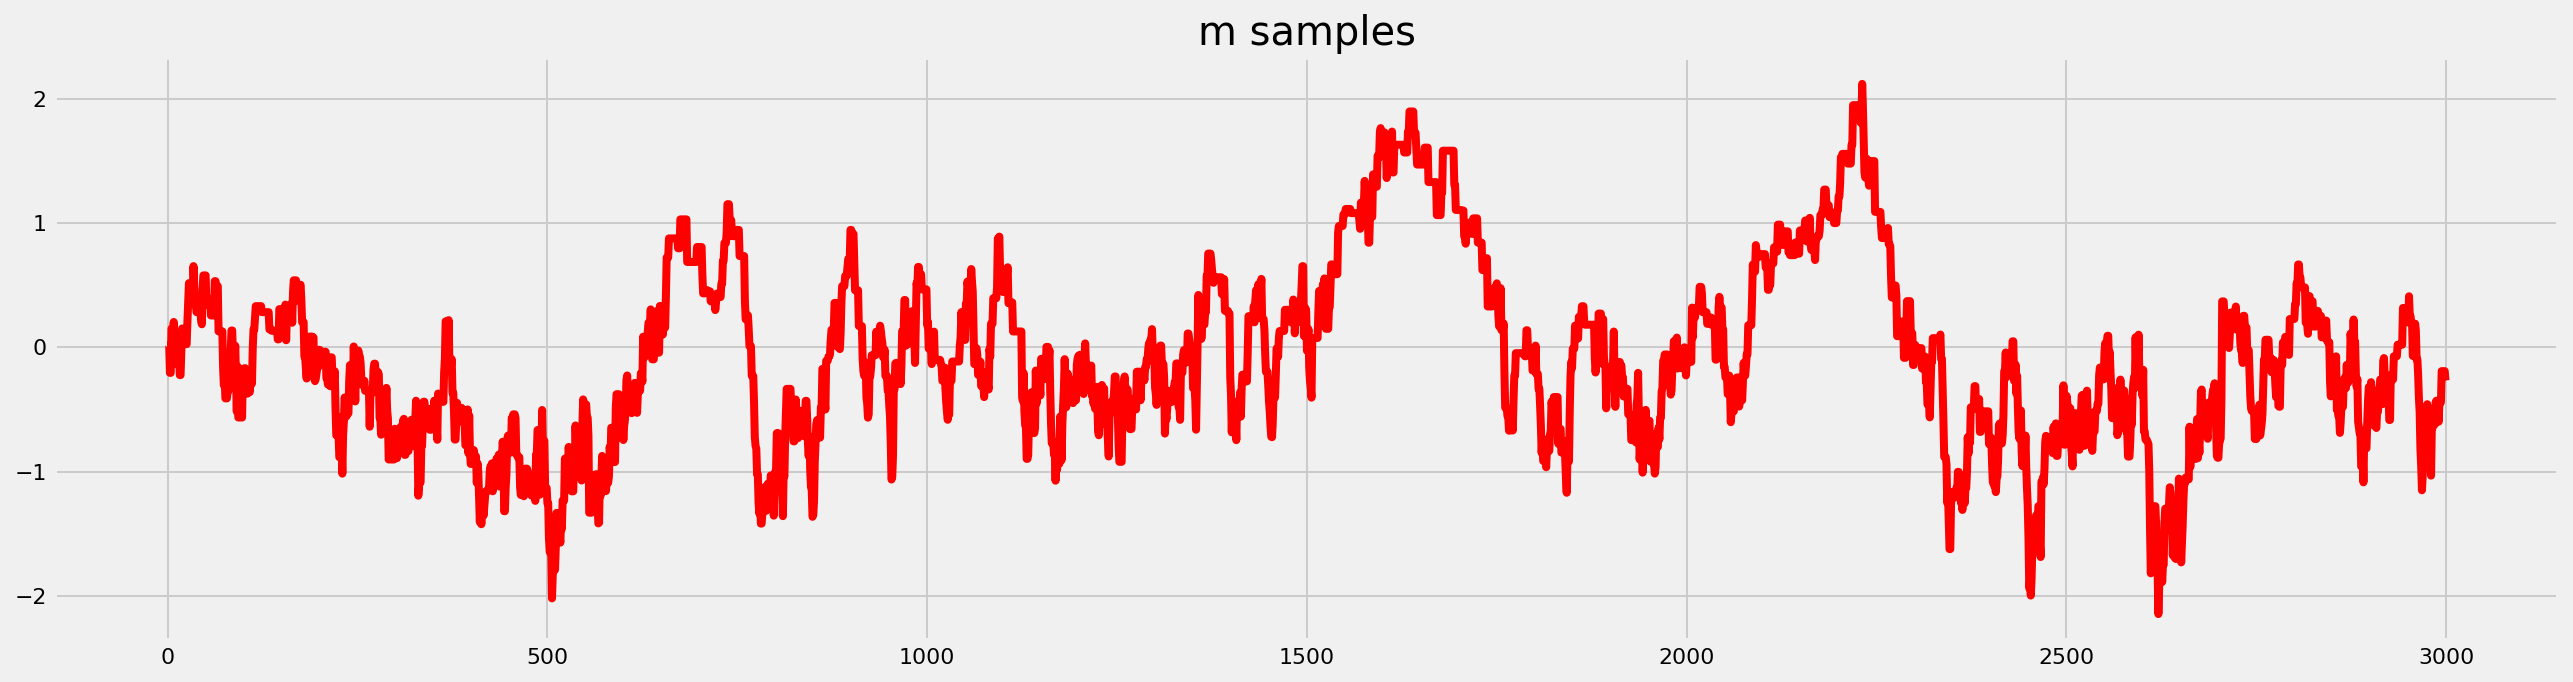

In [157]:
import matplotlib.pyplot as plt; plt.style.use('fivethirtyeight')
# plotting the mcmc chains
plt.figure(figsize=(20,5))
plt.plot(np.arange(samples), logC_samples, color='b')
plt.title('C samples',fontsize=20)

plt.figure(figsize=(20,5))
plt.plot(np.arange(samples), m_samples, color='r')
plt.title('m samples',fontsize=20)

绘制两个变量之间的相关性和分布 （在正确的尺度下）

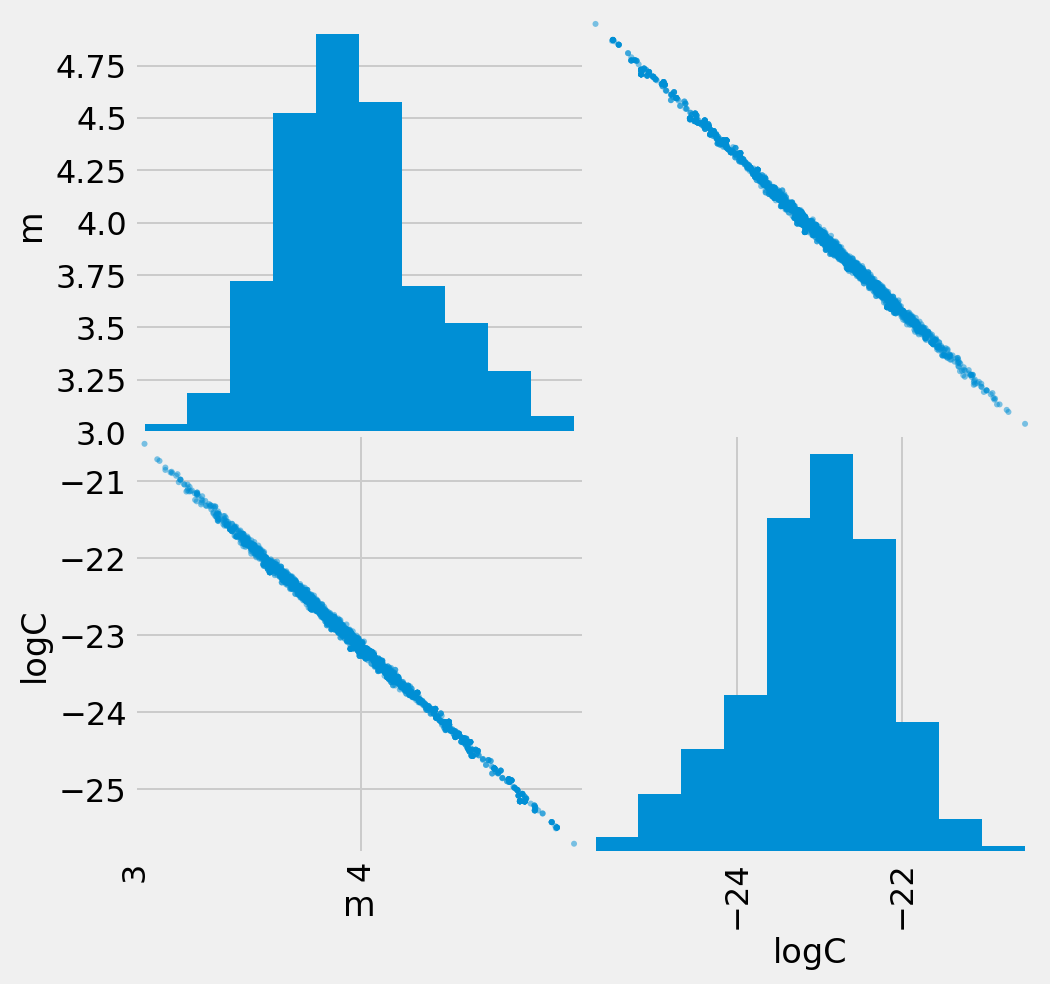

In [158]:
# Converting to proper scale
logC_samples_scale = logC_samples * np.sqrt(prio_par_logC[1]) + prio_par_logC[0]
m_samples_scale = m_samples * np.sqrt(prio_par_m[1]) + prio_par_m[0]
df = pd.DataFrame(np.concatenate([m_samples_scale[:,None], logC_samples_scale[:,None]], axis = 1), columns = ['m', 'logC'])

ax = pd.plotting.scatter_matrix(df,figsize=(7.2,7.2))

for axi in ax:
    axi[0].tick_params(labelsize=16)
    axi[1].tick_params(labelsize=16)

MCMC采样点的统计数据

In [159]:
df.describe(percentiles=[.05, .95])

,m,logC
count,3000.000000,3000.000000
mean,3.961502,-23.048100
std,0.320821,0.861794
min,3.040015,-25.706224
5%,3.481747,-24.620779
50%,3.937382,-22.982691
95%,4.568157,-21.745361
max,4.948502,-20.516314


后验采样。在前面已经通过MCMC采样到了后验分布的，samples = 3000个不同的 $(C,m)$ ，将3000个不同的 $(C,m)$带入到式(1)中，并取不同的time点（cycle）

In [160]:
def posterior(logC_samples, m_samples, time):
    n_s = len(logC_samples)
    # Some Constants
    dsig = 75. # 公式(1) 中 \Delta sigma 取值
    B = tf.constant(dsig * np.pi**0.5, tf.float32)

    # Crack Propagation model - compute in the log space
    y_model =( # 公式(1)
        time[:,None]  *
        tf.exp(logC_samples[None,:])*
        (1-m_samples[None,:]/2.0) *B**m_samples[None,:] +y0** (1-m_samples[None,:]/2.0))**(2. / (2. - m_samples[None,:]))
    noise = tfd.Normal(loc=0., scale=0.001)

    samples = y_model + noise.sample(n_s)[tf.newaxis,:] #引入小噪声 loc=0., scale=0.001
    
    return samples

共30*3000个点，其中time即x轴，对于30个不同的cycles，每个特定cycles对应着3000个不同的crake size（y轴）
其对应着MCMC跑出的samples = 3000个不同的 $(C,m)$ --- 材料的性质服从高斯先验。

In [161]:
# Predict for a range of cycles
time = np.arange(0, 3000, 100) # circle数
y_samples = posterior(logC_samples_scale, m_samples_scale, time)
print(y_samples.shape) # 输出数据的形状

(30, 3000)


绘制出结果

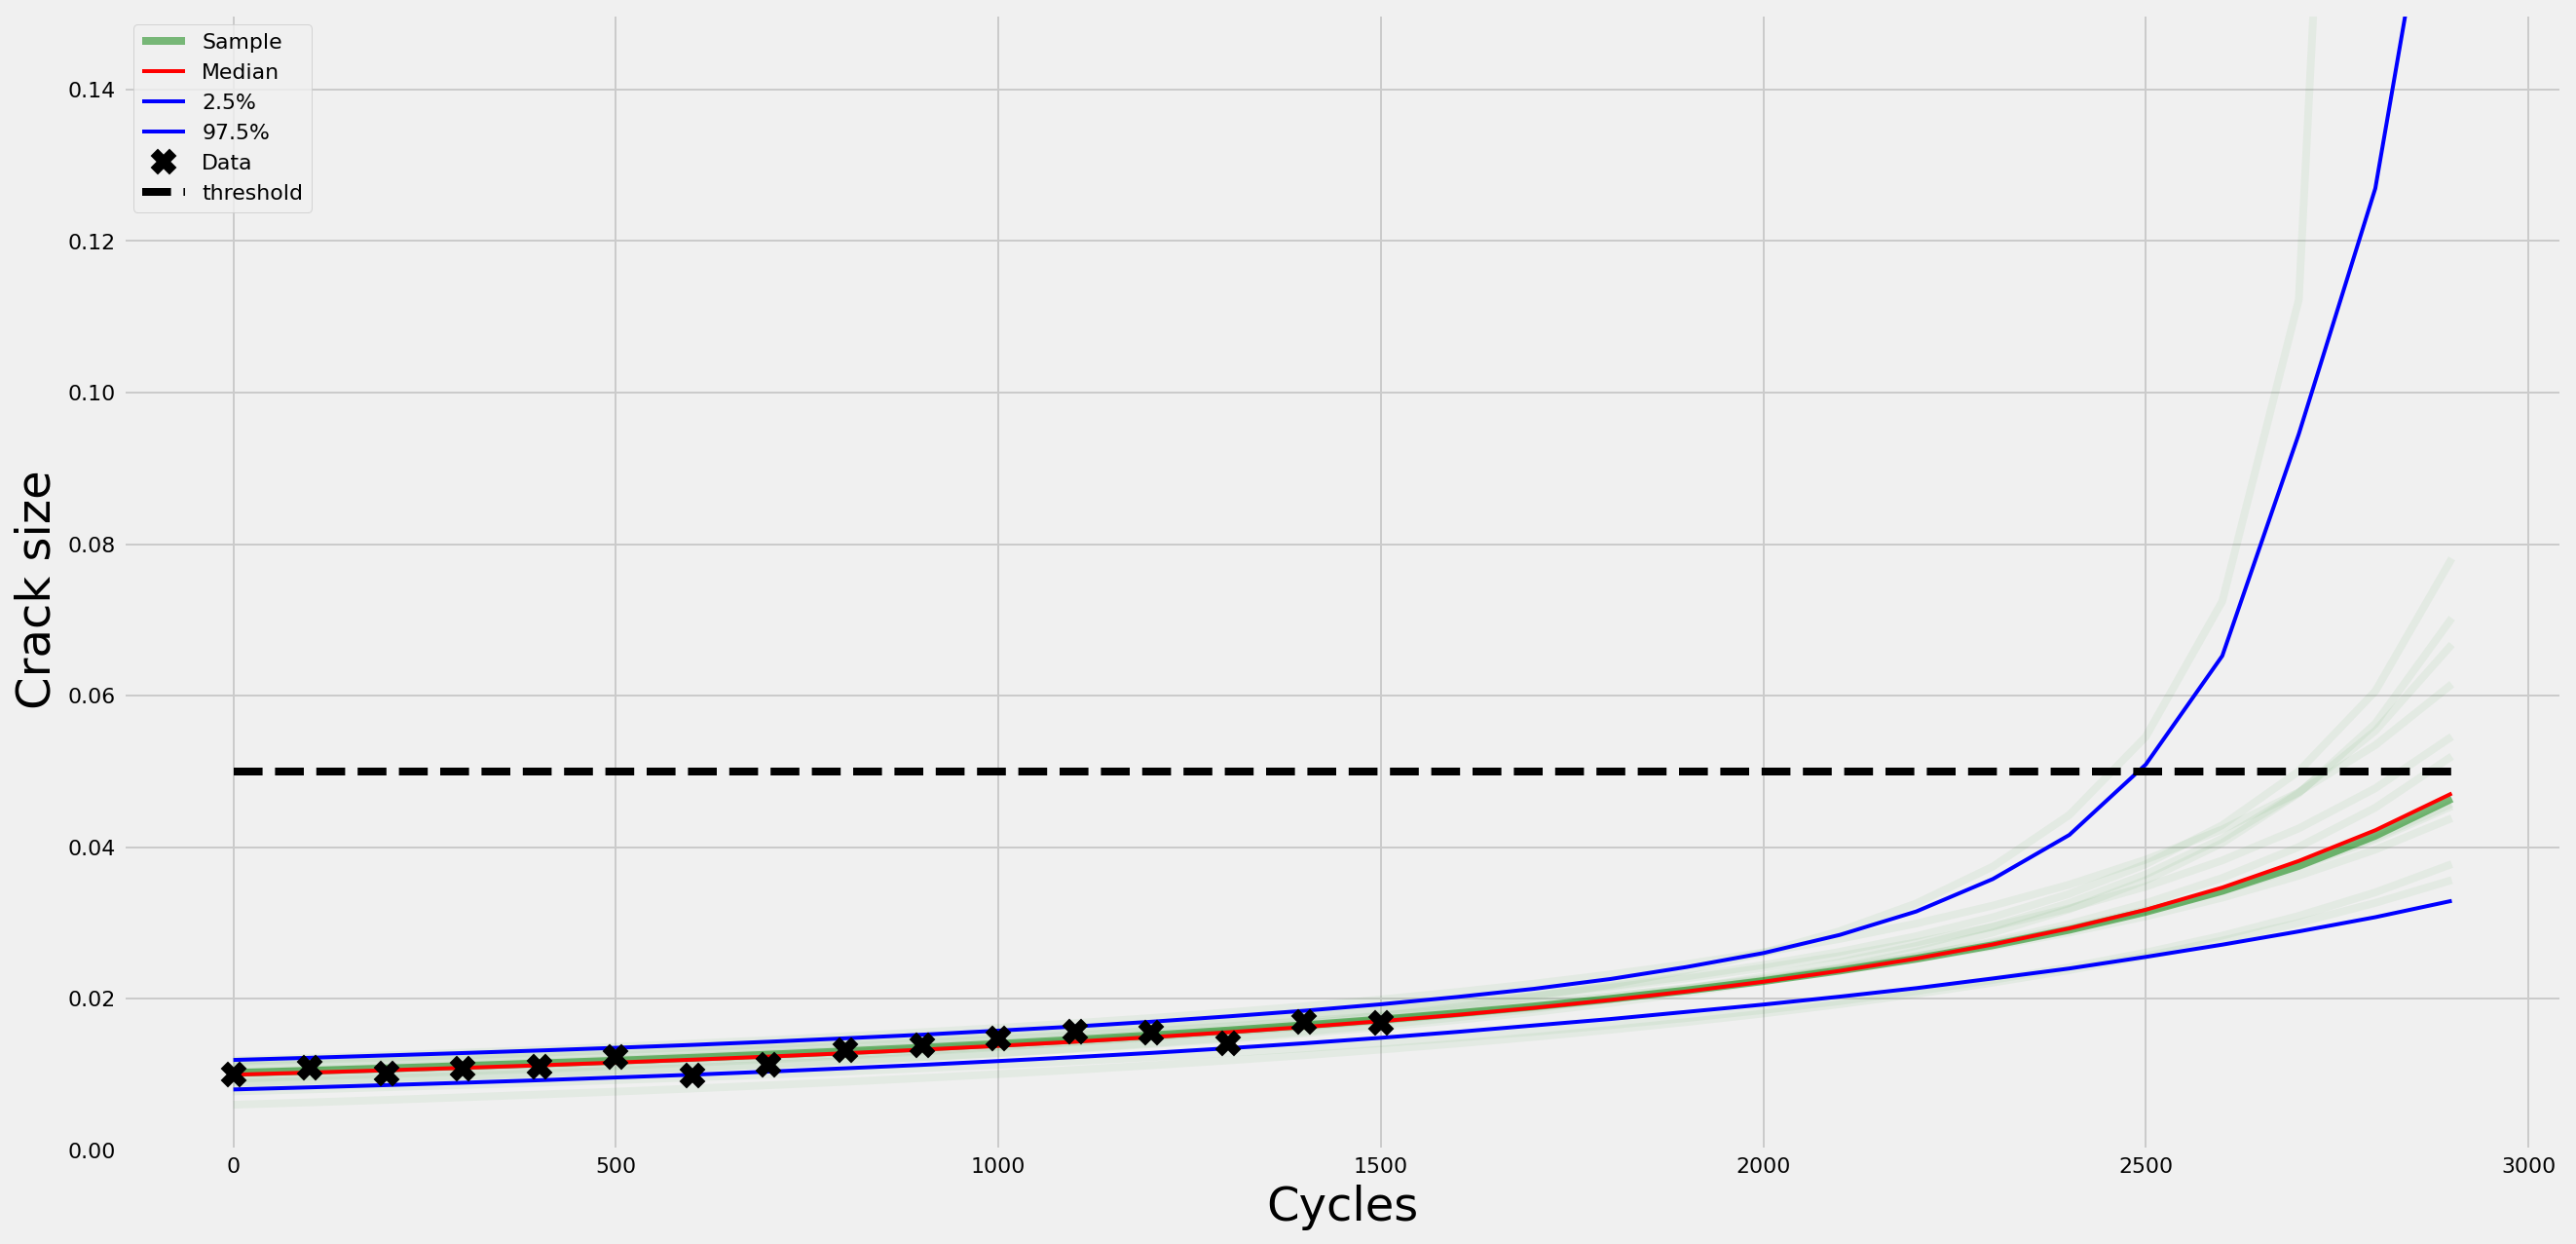

In [162]:
font = {'family' : 'Dejavu Sans','size'   : 20}
matplotlib.rc('font', **font)

#lower_per = np.percentile(y_samples,2.5, axis = 1)
#upper_per = np.percentile(y_samples,97.5, axis = 1)
lower_per = np.nanpercentile(y_samples, 2.5, axis = 1)  #2.5%线
upper_per = np.nanpercentile(y_samples, 97.5, axis = 1) #97.5%线

plt.figure(figsize =(20,10))

for samps in range(y_samples.shape[1]):
    if samps % 250 == 0:
        plt.plot(time, y_samples[:,samps],color='green', alpha = 0.05)

plt.plot(time, y_samples[:,-1],color='green', label='Sample',alpha = 0.5)
plt.plot(time, np.nanmedian(y_samples,axis=1), 'red', label = 'Median',linewidth=2) #中间值
plt.plot(time, lower_per, 'b', label = '2.5%',linewidth=2) #中间值
plt.plot(time, upper_per, 'b', label = '97.5%',linewidth=2) #中间值
plt.plot(t,y,'X', color='black', label = 'Data', markersize=12)
plt.xlabel('Cycles')
plt.ylabel('Crack size ')
plt.hlines(0.05, np.min(time), np.max(time),color='black', linestyles = '--', label = 'threshold')
plt.ylim([-0., 0.15])
plt.legend(loc=2)